In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn 
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from xgboost import XGBClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.decomposition import PCA
from sklearn.decomposition import KernelPCA
from sklearn.inspection import permutation_importance
from sklearn.model_selection import GridSearchCV
from imblearn.over_sampling import RandomOverSampler
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import precision_score, recall_score, accuracy_score, f1_score, classification_report, confusion_matrix, ConfusionMatrixDisplay, PrecisionRecallDisplay, RocCurveDisplay

In [2]:
data = pd.read_csv("../raw_data/file_with_mathtest_features.csv",low_memory=False)

## Variables

In [3]:
data.columns

Index(['hhid', 'Gender', 'mother_alive', 'father_alive', 'parents_age',
       'marital_status', 'darija', 'class_arabic', 'french', 'amazygh',
       'read_one_lang', 'write_one_lang', 'no_read_write', 'parents_level_ed',
       'num_per_house', 'type_housing', 'automobiles', 'mobile_phones',
       'satellite', 'no_water', 'individual_water_net', 'electrical_net_co',
       'school_id', 'child_enrollment', 'class_when_dropout', 'region',
       'province', 'Age abandoned school', 'schoolunitid', 'type_unit',
       'groupid', 'num_menage', 'done_test', 'digit_recognition_res',
       'number_recognition_res', 'subtraction_res', 'division_res',
       'work_activity_classified'],
      dtype='object')

In [4]:
data = data.drop(columns=["Gender","darija","class_arabic","french","amazygh",
                    "read_one_lang","write_one_lang","type_housing","satellite","school_id",
                   "child_enrollment","class_when_dropout","schoolunitid","type_unit","groupid","num_menage",
                   "done_test"])

### Features cleaning (Math Test)

In [5]:
# Digit Recognition
data['digit_recognition_res'] = pd.to_numeric(data['digit_recognition_res'], errors='coerce')
data = data.dropna(subset=['digit_recognition_res'])

In [6]:
# Numbers Recognition
data['number_recognition_res'] = pd.to_numeric(data['number_recognition_res'], errors='coerce')
data = data.dropna(subset=['number_recognition_res'])

In [7]:
# Substraction
data['subtraction_res'] = pd.to_numeric(data['subtraction_res'], errors='coerce')
data = data.dropna(subset=['subtraction_res'])

In [8]:
# Division
data['division_res'] = pd.to_numeric(data['division_res'], errors='coerce')
data = data.dropna(subset=['division_res'])

### Define X, y 

In [9]:
X = data.drop("Age abandoned school", axis=1)
y = data["Age abandoned school"]

In [17]:
X.columns

Index(['hhid', 'mother_alive', 'father_alive', 'parents_age', 'marital_status',
       'no_read_write', 'parents_level_ed', 'num_per_house', 'automobiles',
       'mobile_phones', 'no_water', 'individual_water_net',
       'electrical_net_co', 'region', 'province', 'digit_recognition_res',
       'number_recognition_res', 'subtraction_res', 'division_res',
       'work_activity_classified'],
      dtype='object')

### Remove features columns

In [26]:
X = X.drop(columns=["automobiles","region","province","electrical_net_co","no_water",
                    "no_read_write","digit_recognition_res","number_recognition_res"])

KeyError: "['automobiles', 'region', 'province', 'electrical_net_co', 'no_water', 'no_read_write'] not found in axis"

In [32]:
X.shape

(2969, 14)

## Pipeline preprocessor

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.20)
X_train.shape, X_test.shape, y_train.shape, y_test.shape

X_train.set_index('hhid', inplace=True)
X_test.set_index('hhid', inplace=True)

oversample = RandomOverSampler()
X_train, y_train = oversample.fit_resample(X_train, y_train)

X_train_num = X_train.select_dtypes(include=["float64","int64"])
X_test_num = X_test.select_dtypes(include=["float64","int64"])

pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy="mean")),
    ('standard_scaler', StandardScaler())]).set_output(transform="pandas")

pipeline.fit(X_train_num)
X_train_transformed = pipeline.transform(X_train_num)
X_test_transformed = pipeline.transform(X_test_num)

In [ ]:
X_train_transformed.head()

## PCA & Features Transformation

### PCA

In [ ]:
pca = PCA()
pca.fit(X_train_transformed)

# Metrics
print(pca.explained_variance_ratio_)
print(pca.singular_values_)

# Dimensionality reduction (Train)
X_proj_train = pca.transform(X_train_transformed)
X_proj_train = pd.DataFrame(X_proj_train, columns=[f'PC{i}' for i in range(1, X_train_transformed.shape[1]+1)])
X_proj_train

In [27]:
# Dimensionality reduction (Test)
X_proj_test = pca.transform(X_test_transformed)
X_proj_test = pd.DataFrame(X_proj_test, columns=[f'PC{i}' for i in range(1, X_test_transformed.shape[1]+1)])
X_proj_test

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,PC11,PC12,PC13
0,1.124195,-0.600432,-0.379575,0.168829,0.613583,-0.402597,0.666943,0.816628,-0.615419,-0.011389,1.382120,-0.581556,-0.564635
1,0.601614,0.387811,-0.319618,-1.141246,0.104645,-1.000648,0.731570,-0.859529,0.227177,-0.191875,-0.055690,-1.013877,-0.453452
2,0.210268,0.119656,0.015745,-0.988150,0.468870,0.126373,-2.006177,-1.513651,0.570503,2.052817,0.193258,0.389884,-0.393670
3,-1.668411,-0.768348,0.805857,0.732946,-2.139843,-0.395660,-0.564688,-0.517438,0.118181,0.284127,0.110269,0.478896,0.118377
4,-0.296422,-0.112254,0.514815,-0.239329,-1.374330,-0.006104,-0.468186,-0.002356,1.317756,-0.999233,1.363637,-0.022111,-0.471987
...,...,...,...,...,...,...,...,...,...,...,...,...,...
589,1.450494,0.557885,-0.145585,-1.583413,-0.760535,2.942986,-1.055285,1.444928,1.387464,0.281842,-0.362637,-2.590720,-0.840320
590,3.964302,6.237260,-2.150105,4.207104,-2.087789,-0.082703,-0.868310,-0.152035,1.313924,0.646821,-1.250420,1.073886,-2.937953
591,-1.714048,-0.555066,2.935116,1.613890,-1.052860,-0.851878,-1.068155,-0.142748,-1.786621,-0.472084,0.010077,-0.013624,0.032606
592,1.067494,-2.060468,-0.130381,1.563193,1.461811,-0.946961,-0.785888,-1.519509,-0.725506,-0.055201,0.162778,0.172705,0.122219


### Features permutation

In [28]:
# Fit model
model_nb = GaussianNB().fit(X_proj_train, y_train) 

# Performs Permutation
permutation_score = permutation_importance(model_nb, X_proj_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_proj_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

,feature,score decrease
0,PC1,0.024595
5,PC6,0.009251
2,PC3,0.007909
3,PC4,0.007155
1,PC2,0.006428
7,PC8,0.005646
9,PC10,0.00408
12,PC13,0.002599
8,PC9,0.001845
4,PC5,0.001705


## Model Scoring

In [37]:
def perform(y_true, y_pred):
    print("Precision : ", precision_score(y_true, y_pred))
    print("Recall : ", recall_score(y_true, y_pred))
    print("Accuracy : ", accuracy_score(y_true, y_pred))
    print("F1 Score : ", f1_score(y_true, y_pred))
    cm = confusion_matrix(y_true, y_pred)
    print("\n", cm)
    print("\n")
    print("**"*27 + "\n" + " "* 16 + "Classification Report\n" + "**"*27)
    print(classification_report(y_true, y_pred))
    print("**"*27+"\n")
    
    cm = ConfusionMatrixDisplay(confusion_matrix = cm)
    cm.plot()

### Naive Bayse

Precision :  0.7984886649874056
Recall :  0.6921397379912664
Accuracy :  0.6279461279461279
F1 Score :  0.7415204678362574

 [[ 56  80]
 [141 317]]


******************************************************
                Classification Report
******************************************************
              precision    recall  f1-score   support

         0.0       0.28      0.41      0.34       136
         1.0       0.80      0.69      0.74       458

    accuracy                           0.63       594
   macro avg       0.54      0.55      0.54       594
weighted avg       0.68      0.63      0.65       594

******************************************************



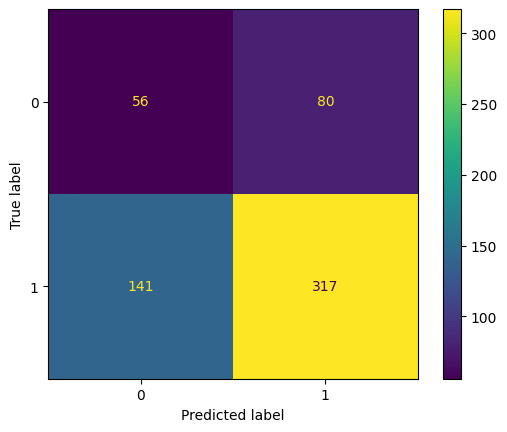

In [38]:
y_pred_nb = model_nb.predict(X_proj_test)
perform(y_test, y_pred_nb)

### SVC 

Precision :  0.8055555555555556
Recall :  0.5698689956331878
Accuracy :  0.5622895622895623
F1 Score :  0.6675191815856778

 [[ 73  63]
 [197 261]]


******************************************************
                Classification Report
******************************************************
              precision    recall  f1-score   support

         0.0       0.27      0.54      0.36       136
         1.0       0.81      0.57      0.67       458

    accuracy                           0.56       594
   macro avg       0.54      0.55      0.51       594
weighted avg       0.68      0.56      0.60       594

******************************************************



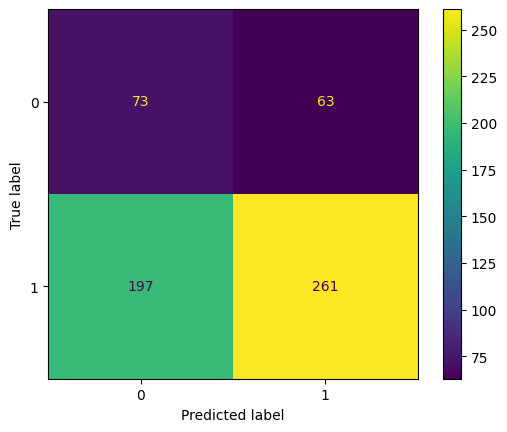

In [39]:
model_svc = SVC()
model_svc.fit(X_proj_train, y_train) 

# Performs Permutation
permutation_score = permutation_importance(model_svc, X_proj_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_proj_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

y_pred_svc = model_svc.predict(X_proj_test)
perform(y_test, y_pred_svc)

### Random Forest

Precision :  0.8251748251748252
Recall :  0.5152838427947598
Accuracy :  0.5420875420875421
F1 Score :  0.6344086021505376

 [[ 86  50]
 [222 236]]


******************************************************
                Classification Report
******************************************************
              precision    recall  f1-score   support

         0.0       0.28      0.63      0.39       136
         1.0       0.83      0.52      0.63       458

    accuracy                           0.54       594
   macro avg       0.55      0.57      0.51       594
weighted avg       0.70      0.54      0.58       594

******************************************************



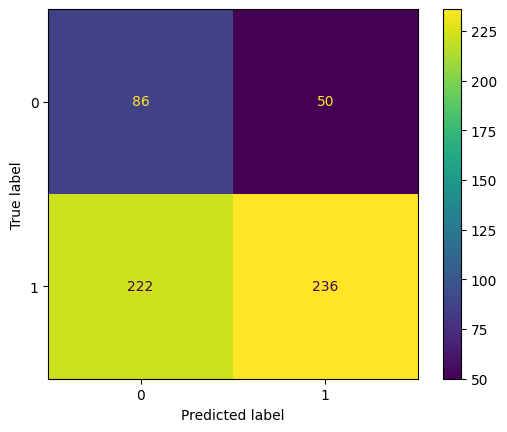

In [40]:
clf = RandomForestClassifier(max_depth=2, random_state=0)

clf.fit(X_proj_train, y_train)

# Performs Permutation
permutation_score = permutation_importance(clf, X_proj_train, y_train, n_repeats=10) 

# Unstack results showing the decrease in performance after shuffling features
importance_df = pd.DataFrame(np.vstack((X_proj_train.columns,
                                        permutation_score.importances_mean)).T) 
importance_df.columns=['feature','score decrease']

# Show the important features
importance_df.sort_values(by="score decrease", ascending = False) 

y_pred_clf = clf.predict(X_proj_test)

perform(y_test, y_pred_clf)

## Precision/Recall trade off 

In [44]:
# To get the predict_proba for a model
proba_dropout, proba_enrolled =cross_val_predict(RandomForestClassifier(),
                                                X_proj_train,
                                                y_train,
                                                cv=5,
                                                method='predict_proba').T

# precision recall data
precision, recall, threshold = precision_recall_curve(y_train, proba_dropout) 

print(f'precision- {precision[:5]}')
print(f'recall- {recall[:5]}')
print(f'threshold- {threshold[:5]}')

precision- [0.5        0.49972036 0.49944009 0.49887892 0.49929874]
recall- [1.         0.99888206 0.99720514 0.99496926 0.99496926]
threshold- [0.         0.01       0.02       0.02333333 0.025     ]


In [50]:
# To view the scores in a DF
scores = pd.DataFrame({'threshold':threshold,
                       'precision': precision[1:],
                       'recall':recall[1:]}) # Store in a dataframe
scores

,threshold,precision,recall
0,0.000000,0.499720,0.998882
1,0.010000,0.499440,0.997205
2,0.020000,0.498879,0.994969
3,0.023333,0.499299,0.994969
4,0.025000,0.499158,0.994410
...,...,...,...
969,0.987143,0.024615,0.004472
970,0.990000,0.029240,0.002795
971,0.994000,0.029412,0.002795
972,0.996667,0.029762,0.002795


Text(0.5, 0, 'recall')

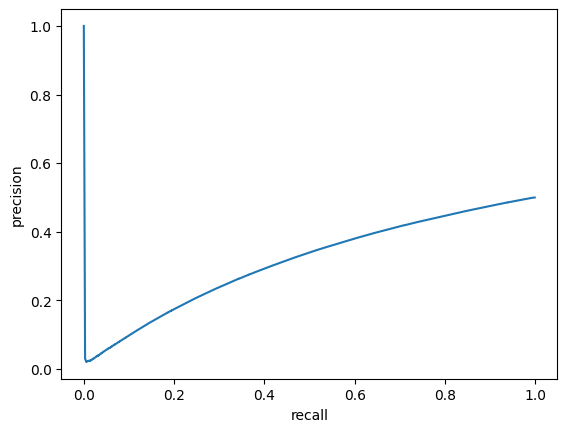

In [51]:
# Plotting Recall vs Precision
plt.plot(scores['recall'],scores['precision'])
plt.ylabel('precision')
plt.xlabel('recall')